# Importing the important libraries and dataset

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [63]:
data = pd.read_csv("spam.csv",encoding='latin1')


### Step 1 Data Cleaning

#### `data.sample(5)` will randomly pick 5 emails from the dataset

In [64]:
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3650,ham,Want to send me a virtual hug?... I need one,NaN,NaN,NaN
1727,ham,I went to project centre,NaN,NaN,NaN
4632,ham,Oh wow thats gay. Will firmware update help,NaN,NaN,NaN
4356,ham,"HELLOGORGEOUS, HOWS U? MY FONE WAS ON CHARGE L...",NaN,NaN,NaN
5193,ham,"It's wylie, you in tampa or sarasota?",NaN,NaN,NaN


In [65]:
data.shape

(5572, 5)

#### Remove unnecessary columns named “Unnamed: 2,” “Unnamed: 3,” and “Unnamed: 4.”

In [66]:
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#### Rename two columns to make them more understandable: “v1” becomes “result,” and “v2” becomes "emails"

In [67]:
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)

#### First five dataset to show the changes

In [68]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check and remove missing or duplicate entries


In [69]:
data.isnull().sum()

result    0
emails    0
dtype: int64

In [70]:
data.duplicated().sum()

np.int64(403)

In [71]:
data = data.drop_duplicates(keep='first')
data.shape

(5169, 2)

In [72]:
data.head()

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Cleaning is done upuntil now

## Step 2 Exploratory Data Analysis

### Pie chart to show the distribution of spam and ham in the data

In [73]:
data['result'].value_counts()

result
ham     4516
spam     653
Name: count, dtype: int64

#### When you use .index, you get the labels

In [74]:
data['result'].value_counts().index

Index(['ham', 'spam'], dtype='object', name='result')

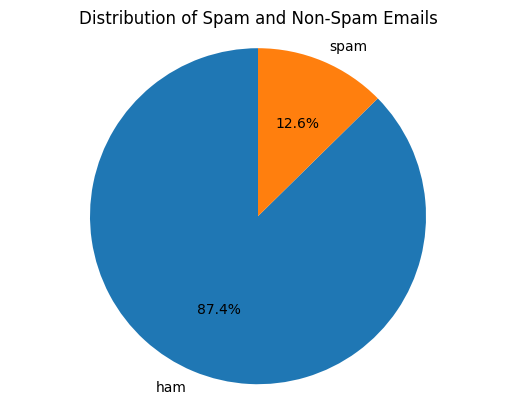

In [75]:
plt.Figure(figsize=(9,9))
plt.pie(data['result'].value_counts(),
        labels=data['result'].value_counts().index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal') 
plt.show()

##### autopct='%1.1f%%'
##### This tells Matplotlib to display percent values on each slice.%1.1f%% means:1 digit before the decimal,1 digit after the decimal.The double % is how you print a literal % sign

##  Average Length of Emails for Spam and Ham

In [76]:
data['length']=data['emails'].apply(len)
data['num_words']=data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)

,result,emails,length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


#### word_tokenize: This function (from the nltk.tokenize module) splits a sentence into individual words. 
#### sent_tokenize: This function (from nltk.tokenize) breaks the text into sentences.